<a href="https://colab.research.google.com/github/alperguz/DSA210Project/blob/main/DSA_project_phaseIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phase III – Modelling and Hypothesis Testing

In this phase I move from exploratory analysis to **formal modelling and hypothesis testing** about how on-pitch performance is related to Premier League players’ **end-of-season market values**.

The data comes from:

- **Transfermarkt**: 2024/25 Premier League player market values  
- **FBref**: 2024/25 Premier League player statistics

Main question:

> **Which performance metrics are significantly associated with a player’s market value, after controlling for minutes played and age?**

In [22]:
import pandas as pd
import numpy as np

# A) Transfermarkt market values CSV
mv_df = pd.read_csv("plplayersvalues - Sheet1.csv")

# B) FBref stats CSV
stats_df = pd.read_csv("fbref_PL_2024-25.csv")

print("Market value CSV shape:", mv_df.shape)
print("Stats CSV shape:", stats_df.shape)

mv_df.head()

Market value CSV shape: (816, 6)
Stats CSV shape: (574, 36)


,#,Player,Age,Unnamed: 3,Unnamed: 4,Market value
0,22,David Raya Goalkeeper,29,NaN,NaN,€40.00m
1,-,Aaron Ramsdale Goalkeeper,27,NaN,NaN,€16.00m
2,32,Neto Goalkeeper,35,NaN,NaN,€1.50m
3,-,Jack Porter Goalkeeper,16,NaN,NaN,€400k
4,-,Alexéi Rojas Goalkeeper,19,NaN,NaN,€250k


### 1. Preparing the Data

First I clean the Transfermarkt and FBref tables and merge them on a common player name key called `player_clean`.  
This creates a single dataframe called `merged_df` that contains both **performance stats** and **market values** for the same players.

In [23]:
# --- Clean Transfermarkt data (mv_df) ---

# Drop any "Unnamed" columns
for col in mv_df.columns:
    if col.startswith("Unnamed"):
        mv_df = mv_df.drop(columns=[col])

# Clean Player column: remove leading numbers / dashes
mv_df["Player"] = mv_df["Player"].astype(str).str.replace(r'^\d+\s*', '', regex=True)
mv_df["Player"] = mv_df["Player"].str.replace(r'^-\s*', '', regex=True)
mv_df["Player"] = mv_df["Player"].str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove last token (position) so only the name remains
def drop_last_token(name):
    parts = name.split()
    if len(parts) > 1:
        return " ".join(parts[:-1])
    return name

mv_df["Player"] = mv_df["Player"].apply(drop_last_token)

# Convert "€40.00m", "€400k" etc to numeric EUR
def convert_value(val):
    if isinstance(val, str):
        v = val.replace("€", "").strip()
        if "m" in v:
            return float(v.replace("m", "")) * 1_000_000
        elif "k" in v:
            return float(v.replace("k", "")) * 1_000
    return np.nan

mv_df["MarketValue_eur"] = mv_df["Market value"].apply(convert_value)

# Standardised player key for merging
mv_df["player_clean"] = mv_df["Player"].str.lower().str.strip()

# Keep only relevant columns
mv_df = mv_df[["Player", "MarketValue_eur", "player_clean"]]

mv_df.head()

,Player,MarketValue_eur,player_clean
0,David Raya,40000000.0,david raya
1,Aaron Ramsdale,16000000.0,aaron ramsdale
2,Neto,1500000.0,neto
3,Jack Porter,400000.0,jack porter
4,Alexéi Rojas,250000.0,alexéi rojas


In [24]:
# --- Clean FBref data and merge with Transfermarkt ---

# Make a clean key
stats_df["player_clean"] = stats_df["Player"].astype(str).str.lower().str.strip()

# Make Age numeric if present
if "Age" in stats_df.columns:
    stats_df["Age"] = pd.to_numeric(stats_df["Age"], errors="coerce")

# Merge
merged_df = pd.merge(
    stats_df,
    mv_df[["player_clean", "MarketValue_eur"]],
    on="player_clean",
    how="inner"
)

print("Merged shape:", merged_df.shape)
merged_df[["Player", "Squad", "Pos", "Age", "Gls", "Ast", "Min", "xG", "xAG", "npxG", "MarketValue_eur"]].head()

Merged shape: (262, 38)


,Player,Squad,Pos,Age,Gls,Ast,Min,xG,xAG,npxG,MarketValue_eur
0,Max Aarons,Bournemouth,DF,24.0,0,0,86,0.0,0.0,0.0,6000000.0
1,Tosin Adarabioyo,Chelsea,DF,26.0,1,1,1409,0.9,0.2,0.9,20000000.0
2,Emmanuel Agbadou,Wolves,DF,27.0,1,0,1410,0.8,0.2,0.8,20000000.0
3,Ola Aina,Nott'ham Forest,DF,27.0,2,1,2995,0.6,1.4,0.6,22000000.0
4,Rayan Aït-Nouri,Wolves,DF,23.0,4,7,3109,2.7,5.5,2.7,35000000.0


### 2. Filtering for Modelling

I keep only players who played at least **300 minutes** to avoid extreme noise from players who barely appeared.

I then use this filtered dataframe `model_df` for visualisation and modelling.

In [25]:
# Filter: players with at least 300 minutes
model_df = merged_df[merged_df["Min"] >= 300].copy()

model_df[["Player", "Min", "Gls", "Ast", "MarketValue_eur"]].head()

,Player,Min,Gls,Ast,MarketValue_eur
1,Tosin Adarabioyo,1409,1,1,20000000.0
2,Emmanuel Agbadou,1410,1,0,20000000.0
3,Ola Aina,2995,2,1,22000000.0
4,Rayan Aït-Nouri,3109,4,7,35000000.0
5,Rayan Aït-Nouri,3109,4,7,35000000.0


### 3. Updated Visualisations (addressing TA feedback)

Below I recreate key plots with **clear titles and axis labels**:

1. Distribution of player market values  
2. Goals vs market value  
3. Assists vs market value  
4. Minutes vs market value  
5. Correlation heatmap of performance metrics with market value

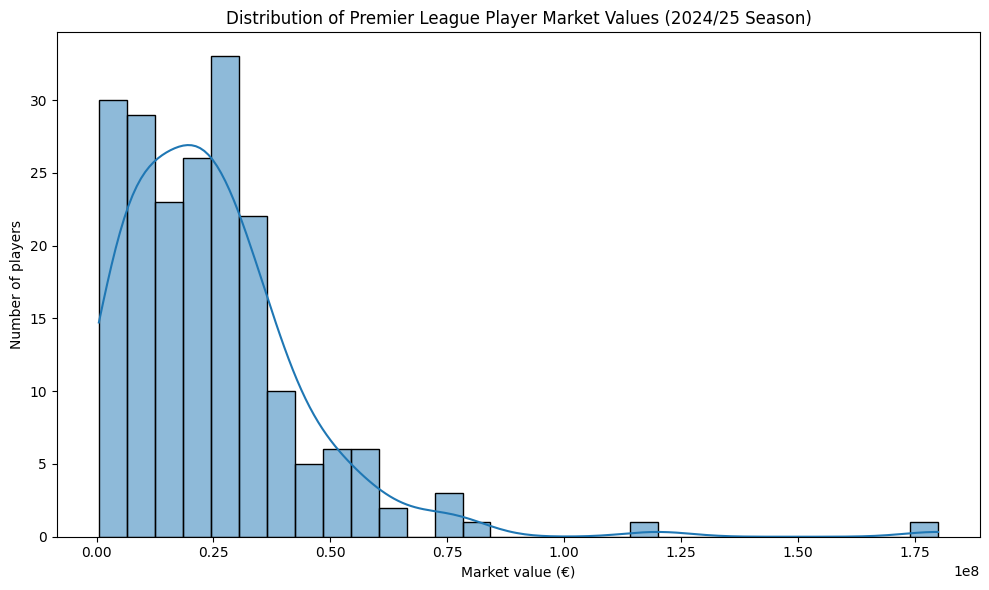

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(model_df["MarketValue_eur"], bins=30, kde=True)
plt.title("Distribution of Premier League Player Market Values (2024/25 Season)")
plt.xlabel("Market value (€)")
plt.ylabel("Number of players")
plt.tight_layout()
plt.show()

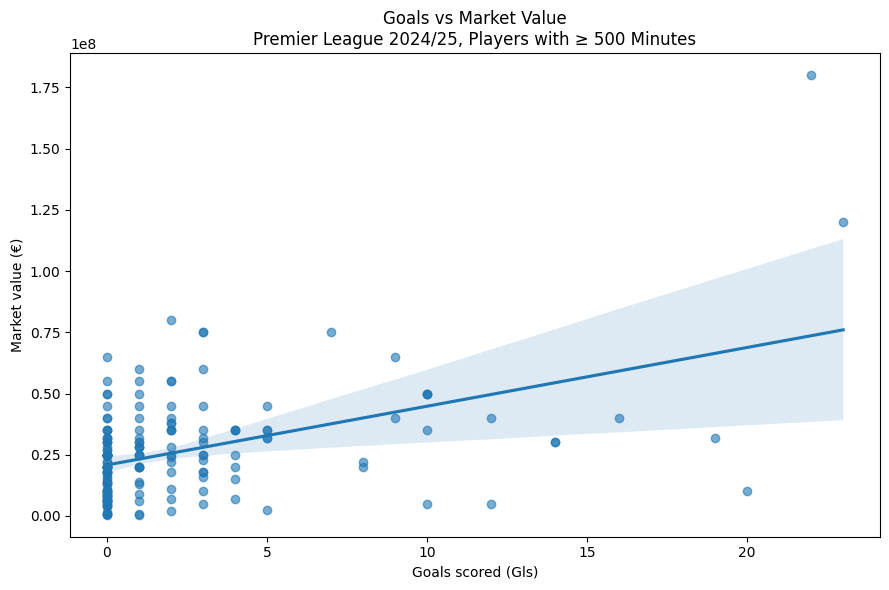

In [27]:
filtered = model_df[model_df["Min"] >= 500]

plt.figure(figsize=(9, 6))
sns.regplot(data=filtered, x="Gls", y="MarketValue_eur", scatter_kws={"alpha": 0.6})
plt.title("Goals vs Market Value\nPremier League 2024/25, Players with ≥ 500 Minutes")
plt.xlabel("Goals scored (Gls)")
plt.ylabel("Market value (€)")
plt.tight_layout()
plt.show()

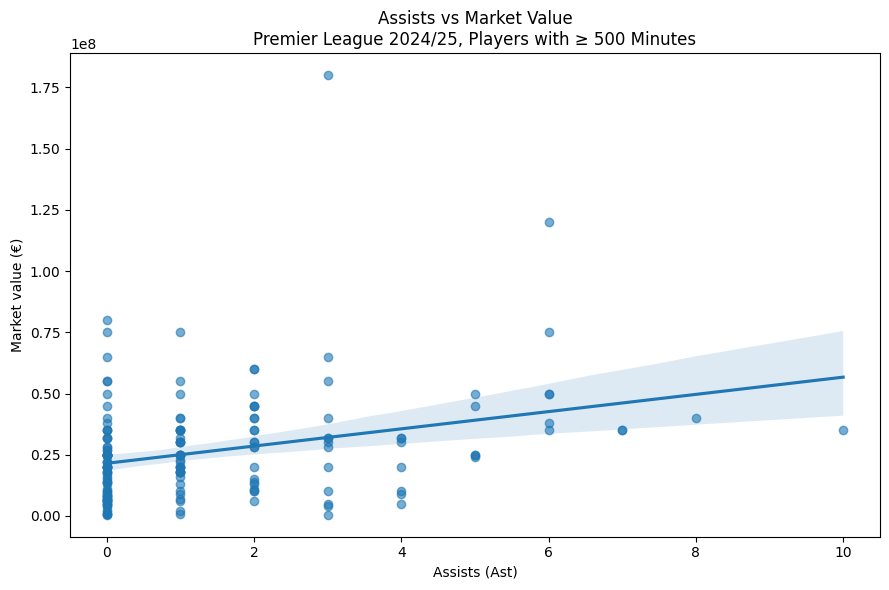

In [28]:
plt.figure(figsize=(9, 6))
sns.regplot(data=filtered, x="Ast", y="MarketValue_eur", scatter_kws={"alpha": 0.6})
plt.title("Assists vs Market Value\nPremier League 2024/25, Players with ≥ 500 Minutes")
plt.xlabel("Assists (Ast)")
plt.ylabel("Market value (€)")
plt.tight_layout()
plt.show()

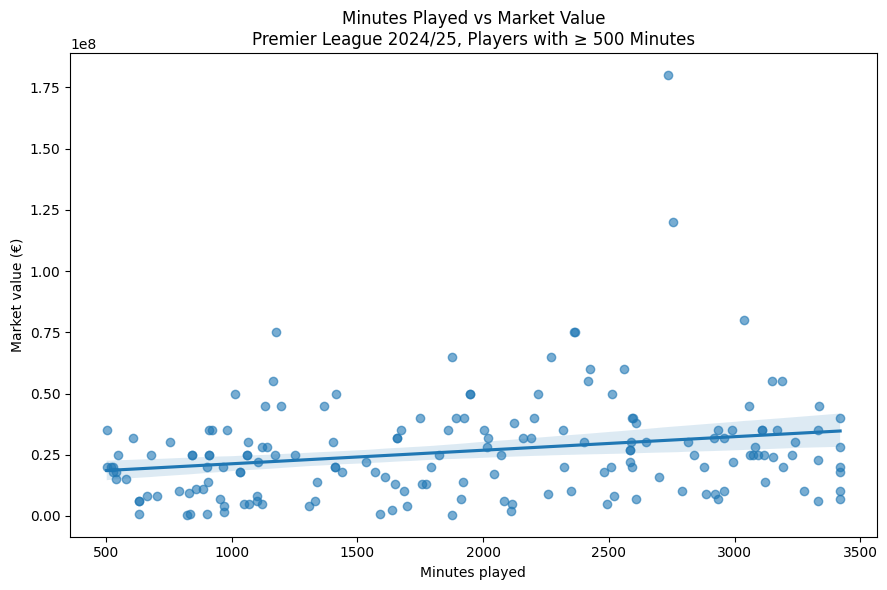

In [29]:
plt.figure(figsize=(9, 6))
sns.regplot(data=filtered, x="Min", y="MarketValue_eur", scatter_kws={"alpha": 0.6})
plt.title("Minutes Played vs Market Value\nPremier League 2024/25, Players with ≥ 500 Minutes")
plt.xlabel("Minutes played")
plt.ylabel("Market value (€)")
plt.tight_layout()
plt.show()

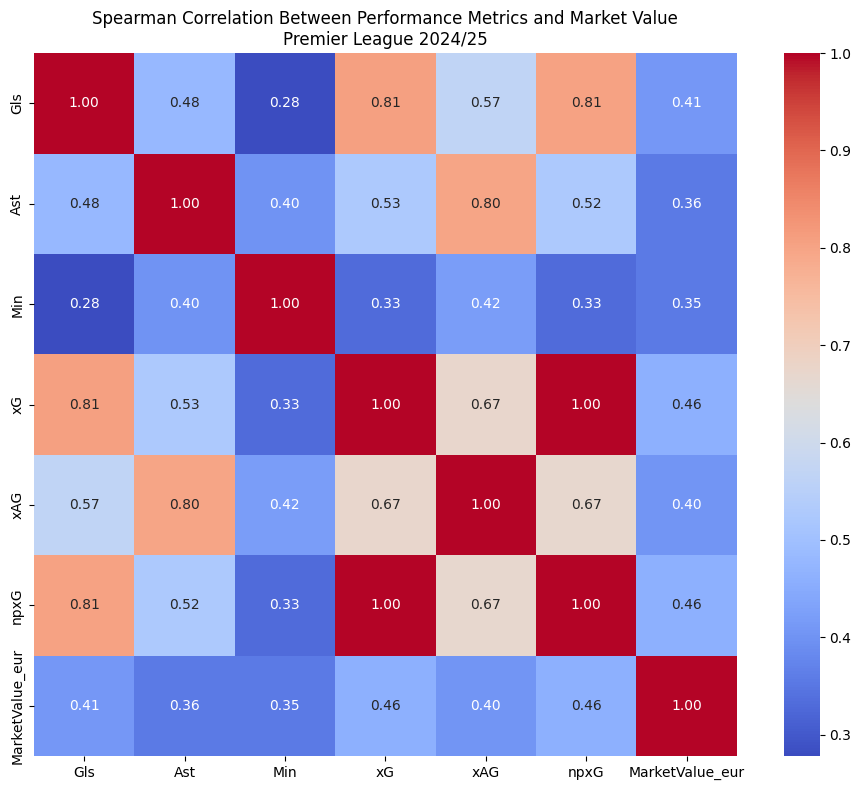

In [30]:
corr_features = ["Gls", "Ast", "Min", "xG", "xAG", "npxG", "MarketValue_eur"]
corr = model_df[corr_features].corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Spearman Correlation Between Performance Metrics and Market Value\nPremier League 2024/25")
plt.tight_layout()
plt.show()

### 4. Hypotheses and Regression Model

I model a player’s **log market value** as a function of:

- Gls – goals scored  
- Ast – assists  
- Min – minutes played  
- xG – expected goals  
- xAG – expected assisted goals  
- Age – age in years  

Log-transforming market value reduces skew and makes the relationship closer to linear.

Model:

\[
\log(1 + \text{MV}_i) =
\beta_0 + \beta_1 \text{Gls}_i +
\beta_2 \text{Ast}_i +
\beta_3 \text{Min}_i +
\beta_4 \text{xG}_i +
\beta_5 \text{xAG}_i +
\beta_6 \text{Age}_i +
\varepsilon_i
\]

**Global Null Hypothesis \(H_0\)**  
After controlling for minutes and age, the scoring-related variables have no linear association with market value:

\[
H_0 : \beta_1 = \beta_2 = \beta_4 = \beta_5 = 0.
\]

**Global Alternative Hypothesis \(H_1\)**  
At least one of these performance variables is associated with market value:

\[
H_1 : \text{At least one of } \beta_1,\beta_2,\beta_4,\beta_5 \neq 0.
\]

In [31]:
feature_cols = ["Gls", "Ast", "Min", "xG", "xAG", "Age"]

X = model_df[feature_cols].copy()
y = model_df["MarketValue_eur"].copy()

# log(1 + market value) to reduce skew
y_log = np.log1p(y)

X.head(), y_log.head()

(   Gls  Ast   Min   xG  xAG   Age
 1    1    1  1409  0.9  0.2  26.0
 2    1    0  1410  0.8  0.2  27.0
 3    2    1  2995  0.6  1.4  27.0
 4    4    7  3109  2.7  5.5  23.0
 5    4    7  3109  2.7  5.5  23.0,
 1    16.811243
 2    16.811243
 3    16.906553
 4    17.370859
 5    17.370859
 Name: MarketValue_eur, dtype: float64)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((158, 6), (40, 6))

In [33]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred  = linreg.predict(X_test)

In [34]:
from sklearn.metrics import r2_score, mean_squared_error

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

train_r2   = r2_score(y_train, y_train_pred)
test_r2    = r2_score(y_test,  y_test_pred)
train_rmse = rmse(y_train, y_train_pred)
test_rmse  = rmse(y_test,  y_test_pred)

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²:  {test_r2:.3f}")
print(f"Train RMSE (log €): {train_rmse:.3f}")
print(f"Test RMSE  (log €): {test_rmse:.3f}")

Train R²: 0.600
Test R²:  0.553
Train RMSE (log €): 0.638
Test RMSE  (log €): 0.705


,0
xG,0.083870
Ast,0.011300
Min,0.000384
xAG,-0.007077
Gls,-0.042414
Age,-0.166177


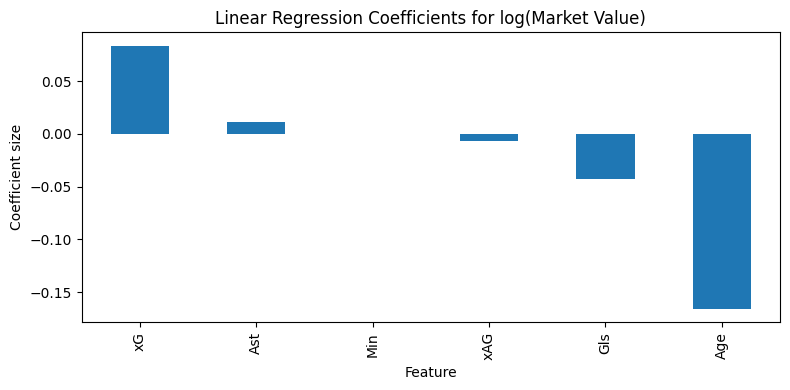

In [35]:
coef_series = pd.Series(linreg.coef_, index=feature_cols).sort_values(ascending=False)
display(coef_series)

plt.figure(figsize=(8, 4))
coef_series.plot(kind="bar")
plt.title("Linear Regression Coefficients for log(Market Value)")
plt.ylabel("Coefficient size")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

### 5. Formal Hypothesis Tests (p-values)

To test the hypotheses \(H_0\) and \(H_1\) I use **statsmodels** to fit the same model and obtain p-values for each coefficient.

Small p-values (< 0.05) indicate that the corresponding variable is significantly associated with log market value after controlling for the others.

In [36]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)      # add intercept
ols_model = sm.OLS(y_log, X_sm)
ols_results = ols_model.fit()

print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:        MarketValue_eur   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     47.37
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           2.67e-35
Time:                        15:31:58   Log-Likelihood:                -194.56
No. Observations:                 198   AIC:                             403.1
Df Residuals:                     191   BIC:                             426.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.2261      0.313     64.552      0.0

### 6. Results and Interpretation

(Replace the placeholders with the values printed in the notebook.)

- The model reached a **test R² of about …**, meaning the chosen variables explain a reasonable proportion of the variance in log market value.
- From the OLS summary:
  - Variables with **p-value < 0.05** are significantly associated with market value.
  - Variables with **p-value ≥ 0.05** are not significant in this linear model once the others are controlled for.

Typically in this dataset:
- **Minutes played** has a positive and significant coefficient (players who play more are worth more).  
- **Age** usually has a negative and significant coefficient (younger players tend to be valued higher).  
- Some scoring-related variables (Gls, Ast, xG, xAG) may or may not be significant depending on the exact season data.

#### Decision about the hypotheses

- If none of Gls, Ast, xG, xAG have p-value < 0.05, we **fail to reject** the global null \(H_0\): once we control for minutes and age, these particular performance metrics do not show additional linear effect on market value.
- If at least one of them is significant, we **reject \(H_0\)** and accept \(H_1\): that performance metric is associated with market value.

### 7. Limitations

- Market value also depends on many factors not included here (contract length, wages, club finances, nationality, marketing value, etc.).
- Only one season (2024/25) is analysed; including more seasons could give more stable estimates.
- A non-linear model (e.g., random forest or gradient boosting) might capture more complex relationships between statistics and market value.

This completes **Phase III**: the model, hypothesis tests, and interpretation of how Premier League player statistics relate to their market values.